In [1]:
CONFIG = {
    'depth': 3,
    'width': 64,
    'lr': 1e-3,
    'weight_decay': 0.0
}

## Constants

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
HIGH_COUNT = 100
LOW_FRAC = 1/64
ZERO_FRAC = 0.5
TEST_COUNT = 100
LOW_RADIUS = 1.
HIGH_RADIUS = 2.
CENTRE = 4 * torch.ones(7)
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

## Data

In [4]:
from scripts.data.orthants import generate_train_data

X_training, Y_training, orthant_counts = generate_train_data(
    low_count=HIGH_COUNT,
    high_count=HIGH_COUNT,
    low_spread=0,
    high_spread=0,
    low_frac=LOW_FRAC,
    zero_frac=ZERO_FRAC,
    centre=CENTRE,
    random_state=535
)
X_training.shape, Y_training.shape

(torch.Size([25400, 7]), torch.Size([25400, 1]))

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2, random_state=375)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([20320, 7]),
 torch.Size([5080, 7]),
 torch.Size([20320, 1]),
 torch.Size([5080, 1]))

In [6]:
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDEX = i
ZERO_ORTHANT_INDEX

99

In [7]:
from scripts.data.orthants import generate_test_data

X_test, Y_test = generate_test_data(TEST_COUNT, CENTRE, random_state=652)
X_test.shape, Y_test.shape

(torch.Size([128, 200, 7]), torch.Size([128, 200, 1]))

In [8]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

In [9]:
X_total_0 = X_train[Y_train.squeeze()==0]
X_total_1 = X_train[Y_train.squeeze()==1]
X_total_0.shape, X_total_1.shape

(torch.Size([10197, 7]), torch.Size([10123, 7]))

In [10]:
from scripts.data.orthants import ORTHANTS

neighboring_orthants = []
for i in range(128):
    if (ORTHANTS[i] * ORTHANTS[ZERO_ORTHANT_INDEX]).sum() == 5:
        neighboring_orthants.append(i)
neighboring_orthants

[35, 67, 97, 98, 103, 107, 115]

In [11]:
X_empty = X_test[ZERO_ORTHANT_INDEX]
Y_empty = Y_test[ZERO_ORTHANT_INDEX]
X_empty_0 = X_empty[Y_empty.squeeze() == 0]
X_empty_1 = X_empty[Y_empty.squeeze() == 1]
X_empty_0.shape, X_empty_1.shape

(torch.Size([100, 7]), torch.Size([100, 7]))

## Neural network

In [12]:
device = 'cpu'

In [13]:
from scripts.models import SimpleNN
from scripts.train import train_model
from scripts.metrics import BinaryAccuracy

In [14]:
model = SimpleNN(7, 1, hidden_layers=CONFIG['depth'], hidden_units=CONFIG['width']).to(device)
model_0 = model.clone()

In [15]:
from scripts.utils import EarlyStopping

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
metric = BinaryAccuracy()
early_stop = EarlyStopping(patience=50, min_delta=1e-4)

In [16]:
history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)
model_inf = model.clone()

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.694586, Train score: 0.498819, Val loss: 0.693683, Val score: 0.497904
Epoch: 2 => Train loss: 0.693396, Train score: 0.500787, Val loss: 0.694114, Val score: 0.482704
Epoch: 3 => Train loss: 0.693208, Train score: 0.503691, Val loss: 0.693806, Val score: 0.492335
Epoch: 4 => Train loss: 0.692824, Train score: 0.510187, Val loss: 0.696041, Val score: 0.490238
Epoch: 5 => Train loss: 0.692379, Train score: 0.512598, Val loss: 0.691526, Val score: 0.504062
Epoch: 6 => Train loss: 0.685577, Train score: 0.536073, Val loss: 0.681259, Val score: 0.546318
Epoch: 7 => Train loss: 0.669429, Train score: 0.565305, Val loss: 0.661301, Val score: 0.583399
Epoch: 8 => Train loss: 0.650280, Train score: 0.587008, Val loss: 0.647401, Val score: 0.582547
Epoch: 9 => Train loss: 0.637484, Train score: 0.610532, Val loss: 0.634549, Val score: 0.610980
Epoch: 10 => Train loss: 0.622619, Train score: 0.633760, Val loss: 0.60

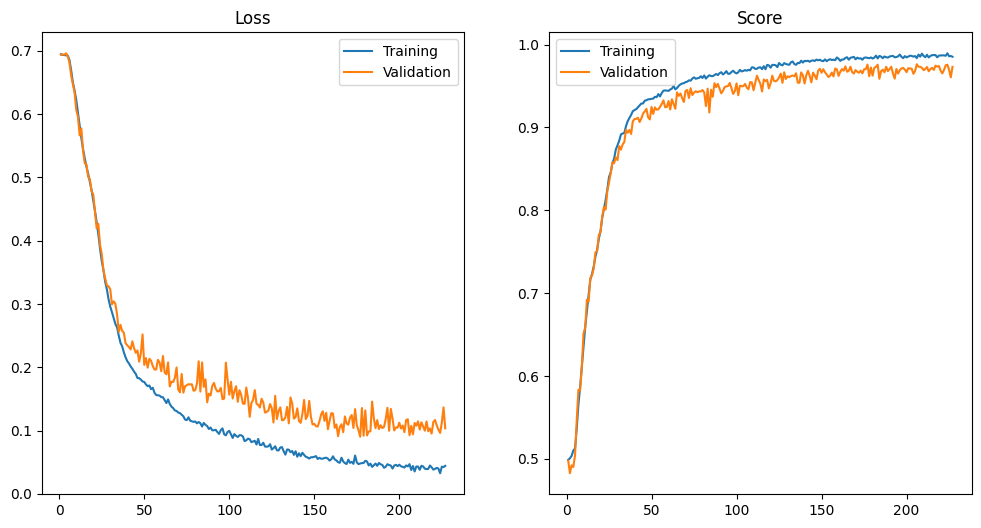

In [17]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [18]:
def get_output_layer_features(model: SimpleNN, u: torch.Tensor) -> torch.Tensor:
    return model.hidden(model.input(u)).detach()

def get_output_layer_feature_matrix(model: SimpleNN, U: torch.Tensor) -> torch.Tensor:
    return torch.cat([get_output_layer_features(model, u).reshape(1, -1) for u in U])

def get_min_dists_inds(x: torch.Tensor, Y: torch.Tensor, labels: torch.Tensor, k: int = 10):
    dists = ((x.reshape(1, -1) - Y)**2).sum(dim=1).sqrt().sort()
    top_inds = dists[1][:k]
    top_dists = dists[0][:k]
    top_classes = torch.tensor([labels[ind].squeeze() for ind in top_inds])
    return torch.cat([top_dists.reshape(-1, 1), top_classes.reshape(-1, 1)], dim=1)

def get_all_min_dists_inds(X: torch.Tensor, Y: torch.Tensor, labels: torch.Tensor, k: int = 10):
    return torch.cat([get_min_dists_inds(x, Y, labels, k).unsqueeze(0) for x in X])

In [19]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(model, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

scores_nn.mean(), scores_nn[ZERO_ORTHANT_INDEX].mean()

(tensor(0.9750), tensor(0.9650))

## Visualizations

In [20]:
COLORS = np.array(['r', 'g'])

In [21]:
outputs_empty = get_output_layer_feature_matrix(model_inf, X_empty_0)
outputs_train = get_output_layer_feature_matrix(model_inf, X_total_0)

In [44]:
min_dists_inds_last = get_all_min_dists_inds(outputs_empty, outputs_train, Y_train)
# min_dists_inds_inc_last = min_dists_inds_last[min_dists_inds_last[:, -1, 0].sort().indices]
min_dists_inds_inc_last = min_dists_inds_last[min_dists_inds_last[:, :, 0].mean(dim=1).sort().indices]

In [23]:
# each pt -> make a colorbar ish thingy, with intensity of green and red corresponding to cumulative num of greens and reds seen so far

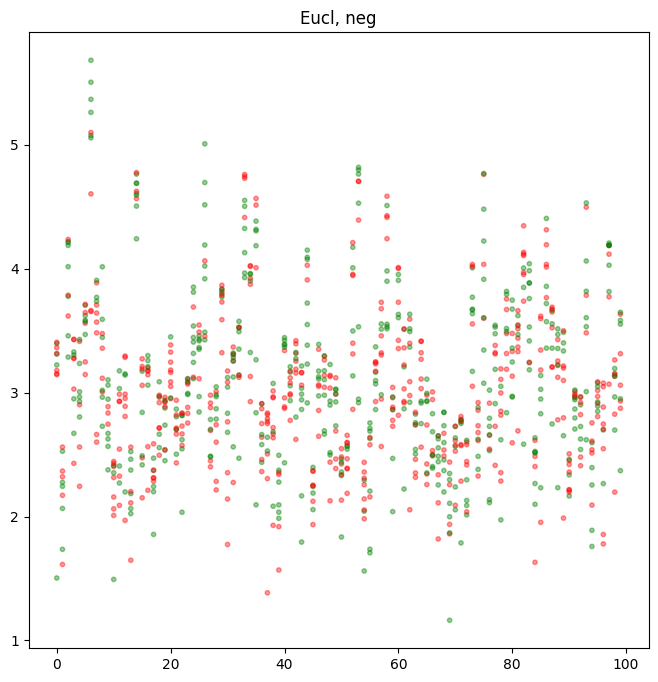

In [24]:
plt.figure(figsize=(8, 8))
        
for i in range(TEST_COUNT): 
    plt.scatter(i*torch.ones(10), min_dists_inds_last[i][:, 0], c=COLORS[min_dists_inds_last[i][:, 1].numpy().astype(int)], s=10, alpha=0.4)
plt.title('Eucl, neg')
plt.show()

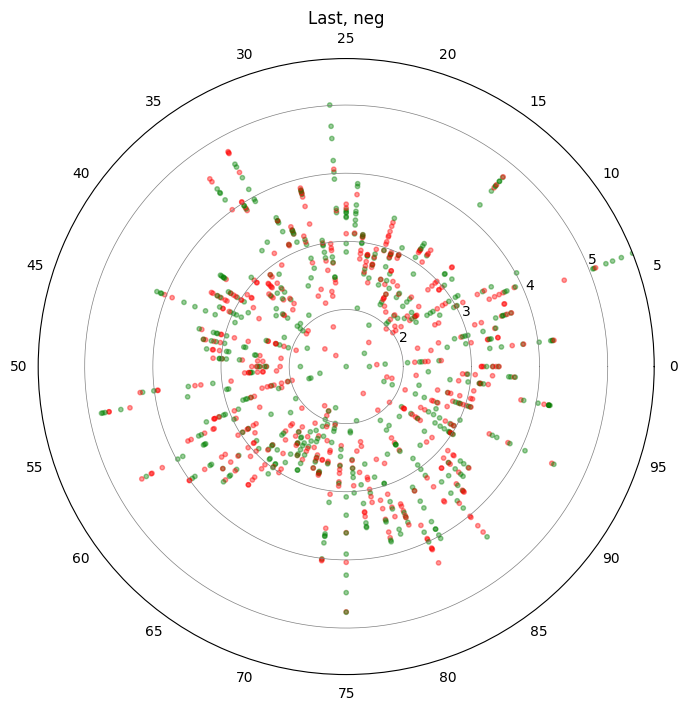

In [49]:
plt.figure(figsize=(8, 8))

plt.subplot(projection='polar')
YLIM = (min_dists_inds_last[:, :, 0].min(), min_dists_inds_last[:, :, 0].max())
for i in range(TEST_COUNT):
    plt.scatter(i*2*torch.pi/100*torch.ones(10), min_dists_inds_last[i][:, 0], c=COLORS[min_dists_inds_last[i][:, 1].numpy().astype(int)], s=10, alpha=0.4)
plt.title('Last, neg')
plt.ylim(YLIM)
plt.xticks(np.array(range(0, 100, 5))*2*torch.pi/100, labels=range(0, 100, 5))
ticks, _ = plt.yticks()
for tick in ticks:
    plt.plot(torch.linspace(0, 2*torch.pi, 360), torch.ones(360)*tick, c='gray', linewidth=0.5)
plt.grid(visible=False)
plt.show()